In [1]:
%load_ext autoreload
%aimport fluidsim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Estimate

In [2]:
from fluidsim.base.preprocess.pseudo_spect import calcul_viscosity

calcul_viscosity(2.5, "forcing", "laplacian", 1, nh=960, Lh=50,
                 coef_dealiasing=8/9, nk_f=6)

Max. wavenumber = 60.31857894892403
Max. resolved wavenumber, k_max = 53.6165146212658
Grid spacing, delta_x = 0.052083333333333336

ESTIMATED (P~eps)
Dissipation wavenumber, k_d = 6.826666666666666; k_d / k_f = 9.054147873672267
Dissipation length scale, L_d = 0.146484375; L_d / L_f = 0.03515625000000001
Viscosity scale: forcing = (1,)
Dissipation, epsilon = 1.0

CALCULATED (eps=1.0)
Dissipation wavenumber, k_d = 6.826666666666668; k_d / k_f = 9.05414787367227
Dissipation length scale, L_d = 0.14648437499999997; L_d / L_f = 0.03515625


{'laplacian': ['nu_2', 2, 0.07721856676956931],
 'hyper4': ['nu_4', 4, 0.0],
 'hyper8': ['nu_8', 8, 0.0],
 'hypo': ['nu_m4', -4, 0.0]}

## Actual simulation

In [20]:
import os
import pandas as pd
from pathlib import Path
from fluidsim.base.output.base import FLUIDDYN_PATH_SCRATCH, FLUIDSIM_PATH
tmp = Path(FLUIDDYN_PATH_SCRATCH)
data = Path(FLUIDSIM_PATH)

paths = (tmp / "laplacian").glob("*")
paths = sorted(paths)
paths_finished = (data/ "laplacian").glob("*")
paths.extend(paths_finished)

In [24]:
from fluiddyn.io import stdout_redirected
import fluidsim as fls
def init_df(path):
    with stdout_redirected():
        sim = fls.load_sim_for_plot(str(path))
        dico_sp = sim.output.spatial_means.load()
        dico = sim.output.spectra.load2d_mean()
    kmax = dico["kh"].max()
    tmax = dico_sp["t"].max()
    dealias = sim.params.oper.coef_dealiasing
    ratio = sim.params.preprocess.viscosity_const*np.pi
    kdiss = kmax / ratio
    last_file = sorted(path.glob("state_phys*"))[-1].name
    return {
        "short name": os.path.basename(path),
        "kmax": kmax,
        "kmax_resolved": kmax * dealias,
        "k_d": kdiss,
        "kmax_by_kdiss": ratio,
        "c": sim.params.c2 ** 0.5,
        "$n$": sim.params.oper.nx,
        "nu": sim.params.nu_2,
        "visc_const": sim.params.preprocess.viscosity_const,
        "dealias": dealias,
        "tmax": tmax,
    }

In [26]:
df = pd.DataFrame({"path": paths})

params = df.path.apply(init_df)
df_params = pd.DataFrame(list(params))
df = df.join(df_params)
df = df.sort_values("c")
df

,path,$n$,c,dealias,k_d,kmax,kmax_by_kdiss,kmax_resolved,nu,short name,tmax,visc_const
2,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,960,10.0,0.888889,7.68,60.318579,7.853982,53.616515,0.077219,SW1Lwaves_noise_c=10_Bu=inf_beta=0.0_960x960_S...,24.963056,2.5
0,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,960,40.0,0.888889,7.68,60.318579,7.853982,53.616515,0.077219,SW1Lwaves_noise_c=40_Bu=inf_beta=0.0_960x960_S...,24.964844,2.5
1,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,960,100.0,0.888889,7.68,60.318579,7.853982,53.616515,0.077219,SW1Lwaves_noise_c=100_Bu=inf_beta=0.0_960x960_...,24.906250,2.5


In [27]:
path_dir = df.iloc[-1].path
# os.chdir(path_dir)
path_dir

PosixPath('/scratch/avmo/data/laplacian/SW1Lwaves_noise_c=100_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21')

## Shock seperation

In [35]:
dict_paths = dict(zip(df["short name"], df.path))
dict_paths

{'SW1Lwaves_noise_c=10_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21': PosixPath('/scratch/avmo/data/laplacian/SW1Lwaves_noise_c=10_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21'),
 'SW1Lwaves_noise_c=40_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21': PosixPath('/scratch/avmo/data/laplacian/SW1Lwaves_noise_c=40_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21'),
 'SW1Lwaves_noise_c=100_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21': PosixPath('/scratch/avmo/data/laplacian/SW1Lwaves_noise_c=100_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21')}

In [86]:
from peak_detection import run

run(0, df=df, save_as="dataframes/shock_sep_laplacian.csv", dict_paths=dict_paths)

/scratch/avmo/data/laplacian/SW1Lwaves_noise_c=10_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21
/scratch/avmo/data/laplacian/SW1Lwaves_noise_c=40_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21
/scratch/avmo/data/laplacian/SW1Lwaves_noise_c=100_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21


/scratch/avmo/src/latex/augier_vishnu_lindborg_sw1l/Python/peak_detection.py:45: RuntimeWarning: Mean of empty slice.
  
/scratch/avmo/miniconda3/envs/gfdyn/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,0,1
2,9.333435,0.316056
0,5.524590,0.163101
1,2.716669,0.048326


In [88]:
from paths import load_df
df_shocks = load_df("shock_sep_laplacian")
df_shocks

,path,mean,std
# short_name,,,
SW1Lwaves_noise_c=10_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,9.333435,0.316056
SW1Lwaves_noise_c=40_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,5.524590,0.163101
SW1Lwaves_noise_c=100_Bu=inf_beta=0.0_960x960_S50x50_2018-11-06_16-36-21,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,2.716669,0.048326


In [111]:
df["d"] = df_shocks["mean"].values
df

,path,$n$,c,dealias,k_d,kmax,kmax_by_kdiss,kmax_resolved,nu,short name,tmax,visc_const,d
2,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,960,10.0,0.888889,7.68,60.318579,7.853982,53.616515,0.077219,SW1Lwaves_noise_c=10_Bu=inf_beta=0.0_960x960_S...,24.963056,2.5,9.333435
0,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,960,40.0,0.888889,7.68,60.318579,7.853982,53.616515,0.077219,SW1Lwaves_noise_c=40_Bu=inf_beta=0.0_960x960_S...,24.964844,2.5,5.524590
1,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,960,100.0,0.888889,7.68,60.318579,7.853982,53.616515,0.077219,SW1Lwaves_noise_c=100_Bu=inf_beta=0.0_960x960_...,24.906250,2.5,2.716669


Text(0,0.5,'$d$')

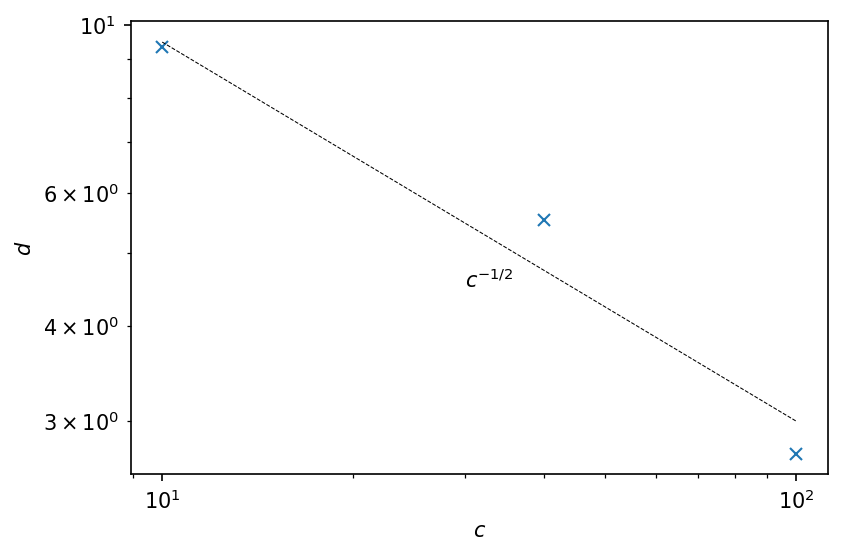

In [115]:
%matplotlib inline
plt.figure(dpi=150)
plt.loglog("c", "d", 'x', data=df)
plt.plot(df.c, 30 * df.c ** (-0.5), "k--", linewidth=0.5)
plt.text(30, 4.5, "$c^{-1/2}$")
plt.xlabel("$c$")
plt.ylabel("$d$")

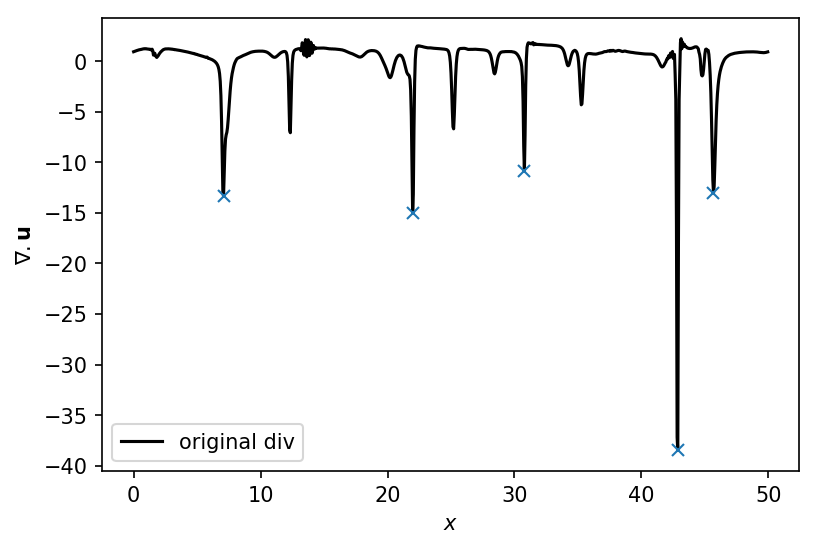

In [102]:
%%capture --no-display
from peak_detection import detect_shocks

path = df.path.iloc[0]
sim = fls.load_state_phys_file(path)
detect_shocks(sim, 300, 200, debug=True)

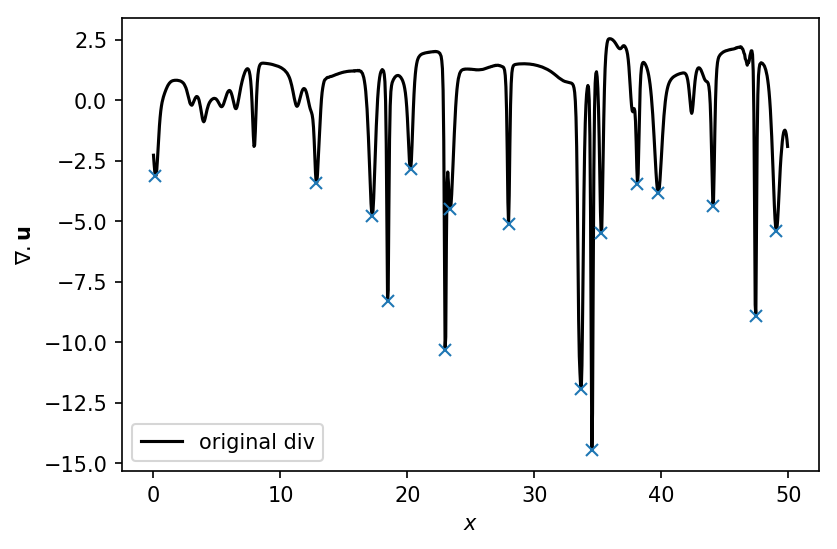

In [104]:
%%capture --no-display
from peak_detection import detect_shocks

path = df.path.iloc[1]
sim = fls.load_state_phys_file(path)
detect_shocks(sim, 300, 200, debug=True)

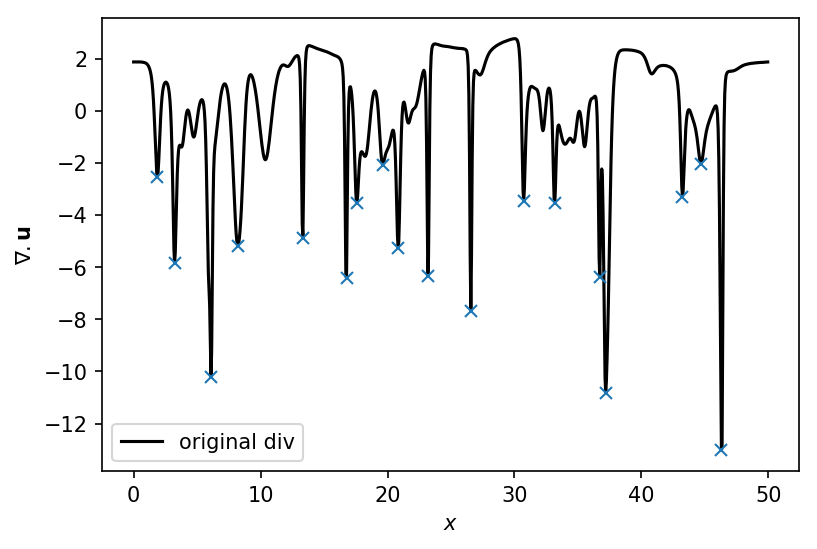

In [103]:
%%capture --no-display
from peak_detection import detect_shocks

path = df.path.iloc[2]
sim = fls.load_state_phys_file(path)
detect_shocks(sim, 300, 200, debug=True)

In [107]:
df

,path,$n$,c,dealias,k_d,kmax,kmax_by_kdiss,kmax_resolved,nu,short name,tmax,visc_const
2,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,960,10.0,0.888889,7.68,60.318579,7.853982,53.616515,0.077219,SW1Lwaves_noise_c=10_Bu=inf_beta=0.0_960x960_S...,24.963056,2.5
0,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,960,40.0,0.888889,7.68,60.318579,7.853982,53.616515,0.077219,SW1Lwaves_noise_c=40_Bu=inf_beta=0.0_960x960_S...,24.964844,2.5
1,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,960,100.0,0.888889,7.68,60.318579,7.853982,53.616515,0.077219,SW1Lwaves_noise_c=100_Bu=inf_beta=0.0_960x960_...,24.906250,2.5


# Flatness

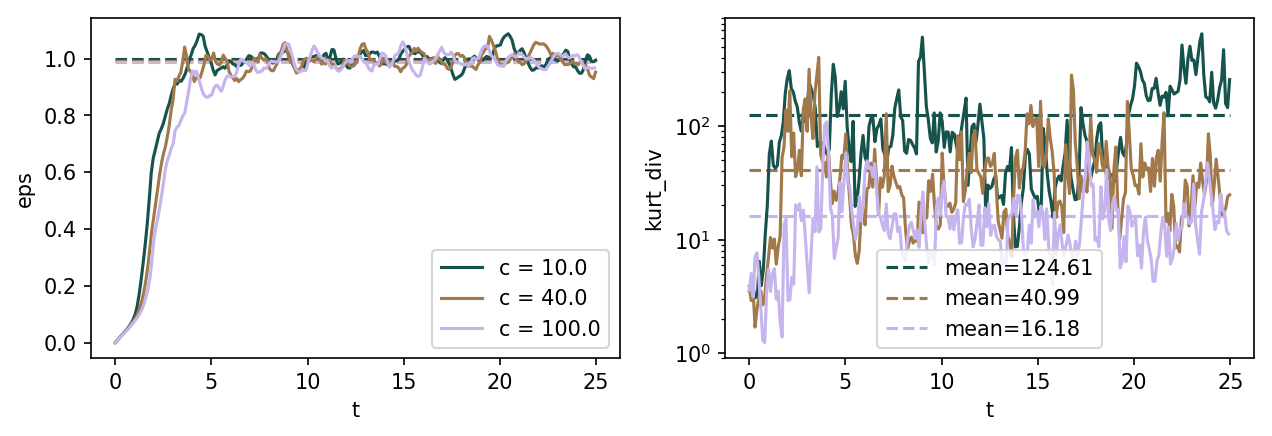

In [123]:
%%capture --no-display
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=150)
colors = [mpl.colors.to_hex(c) for c in sns.color_palette("cubehelix", len(df))]


kurt_div = []
for path, color in zip(df.path, colors):
    sim = fls.load_sim_for_plot(path)
    dset = sim.output.spatial_means.load_dataset()
    idx = int(abs(dset.t  - 5).argmin())

    dset["eps"] = (dset.epsK_tot + dset.epsA_tot)
    eps = dset.eps
    eps.plot(ax=ax[0], c=color, label=f"c = {sim.params.c2**0.5}")
    ax[0].hlines(eps[idx:].mean(), xmin=dset.t.min(), xmax=dset.t.max(),color=color, label="", linestyle='--')

        
    dset.kurt_div.plot(ax=ax[1], c=color, label="")
    kurt_mean = dset.kurt_div[idx:].mean()
    ax[1].hlines(kurt_mean, xmin=dset.t.min(), xmax=dset.t.max(), color=color, linestyle="--",
                 label=f'mean={float(kurt_mean):.2f}')

    kurt_div.append(float(kurt_mean))

df["kurt_div"] = kurt_div
    
ax[0].legend()
ax[1].legend()
ax[1].set_yscale("log")
# ax.set_ylim(0.96,1.05)
# ax.set_xlim(0, 50)

In [124]:
df

,path,$n$,c,dealias,k_d,kmax,kmax_by_kdiss,kmax_resolved,nu,short name,tmax,visc_const,d,kurt_div
2,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,960,10.0,0.888889,7.68,60.318579,7.853982,53.616515,0.077219,SW1Lwaves_noise_c=10_Bu=inf_beta=0.0_960x960_S...,24.963056,2.5,9.333435,124.609321
0,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,960,40.0,0.888889,7.68,60.318579,7.853982,53.616515,0.077219,SW1Lwaves_noise_c=40_Bu=inf_beta=0.0_960x960_S...,24.964844,2.5,5.524590,40.993562
1,/scratch/avmo/data/laplacian/SW1Lwaves_noise_c...,960,100.0,0.888889,7.68,60.318579,7.853982,53.616515,0.077219,SW1Lwaves_noise_c=100_Bu=inf_beta=0.0_960x960_...,24.906250,2.5,2.716669,16.179333


Text(0,0.5,'flatness of divergence')

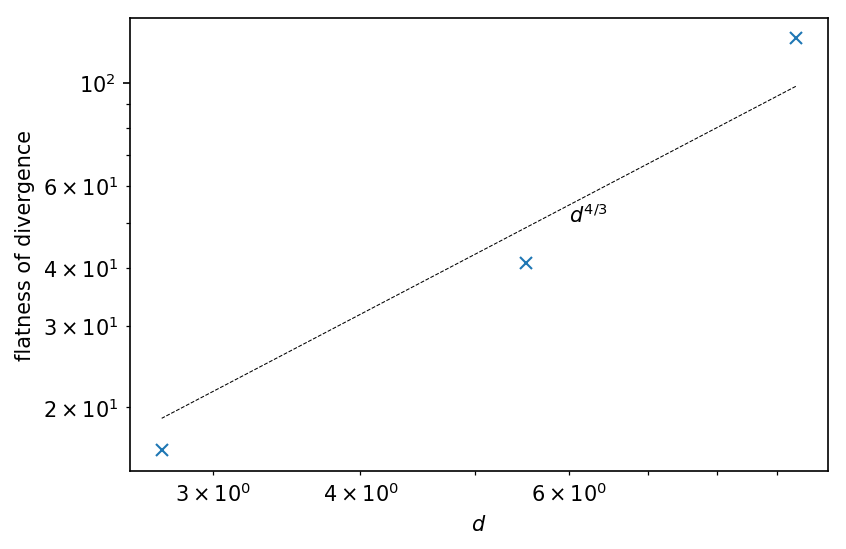

In [133]:
%matplotlib inline
plt.figure(dpi=150)
plt.loglog("d", "kurt_div", 'x', data=df)
plt.plot(df.d, 5 * df.d ** (4/3), "k--", linewidth=0.5)
plt.text(6, 50, "$d^{4/3}$")
plt.xlabel("$d$")
plt.ylabel("flatness of divergence")

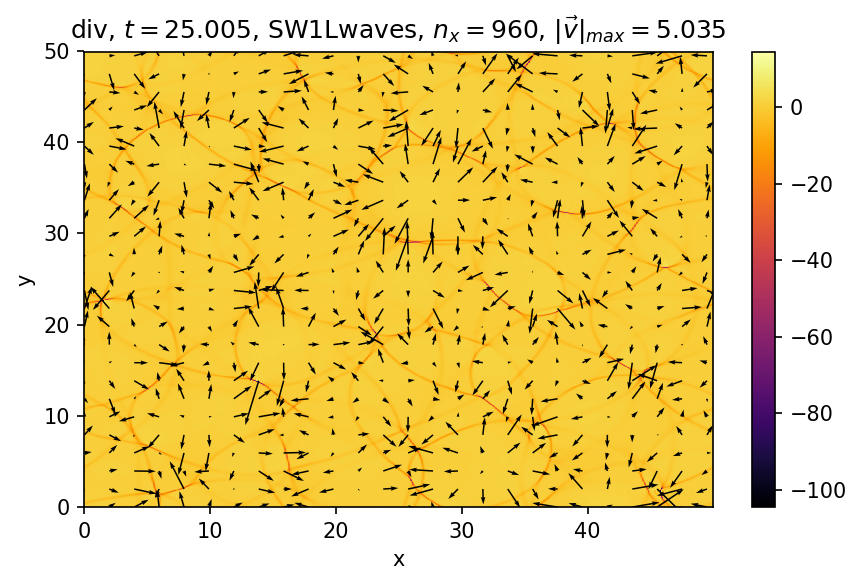

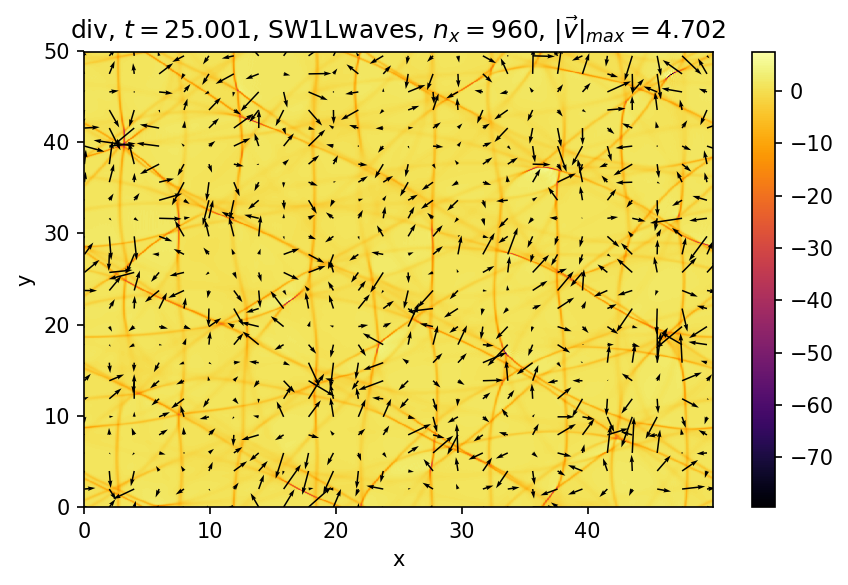

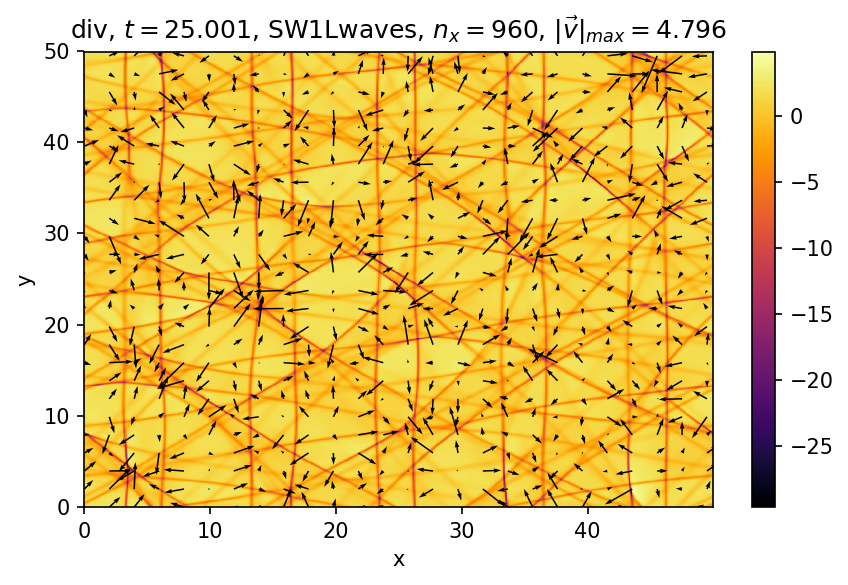

In [64]:
%%capture --no-display
for path in df.path:
    sim = fls.load_state_phys_file(path)
    print(f"c = {sim.params.c2**0.5}")
    plt.rc("figure", dpi=150)
    sim.output.phys_fields.plot("div", cmap="inferno", type_plot="pcolor")
    # sim.output.phys_fields.plot("uy", cmap="inferno", type_plot="pcolor")

## Mean energy, forcing, dissipation

In [79]:
sim.params.preprocess.viscosity_const

2.25

In [80]:
sim.output.spectra.plot2d?

Signature: sim.output.spectra.plot2d(tmin=0, tmax=1000, delta_t=2, coef_compensate=3, coef_norm=None, keys=['Etot', 'EK', 'Eglin', 'Ealin'], colors=['k', 'r', 'g', 'y'], kh_norm=1, ax=None, help_lines=True)
Docstring: <no docstring>
File:      /scratch/avmo/src/gfdyn/fluidsim/fluidsim/solvers/sw1l/output/spectra.py
Type:      method


/scratch/avmo/miniconda3/envs/gfdyn/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


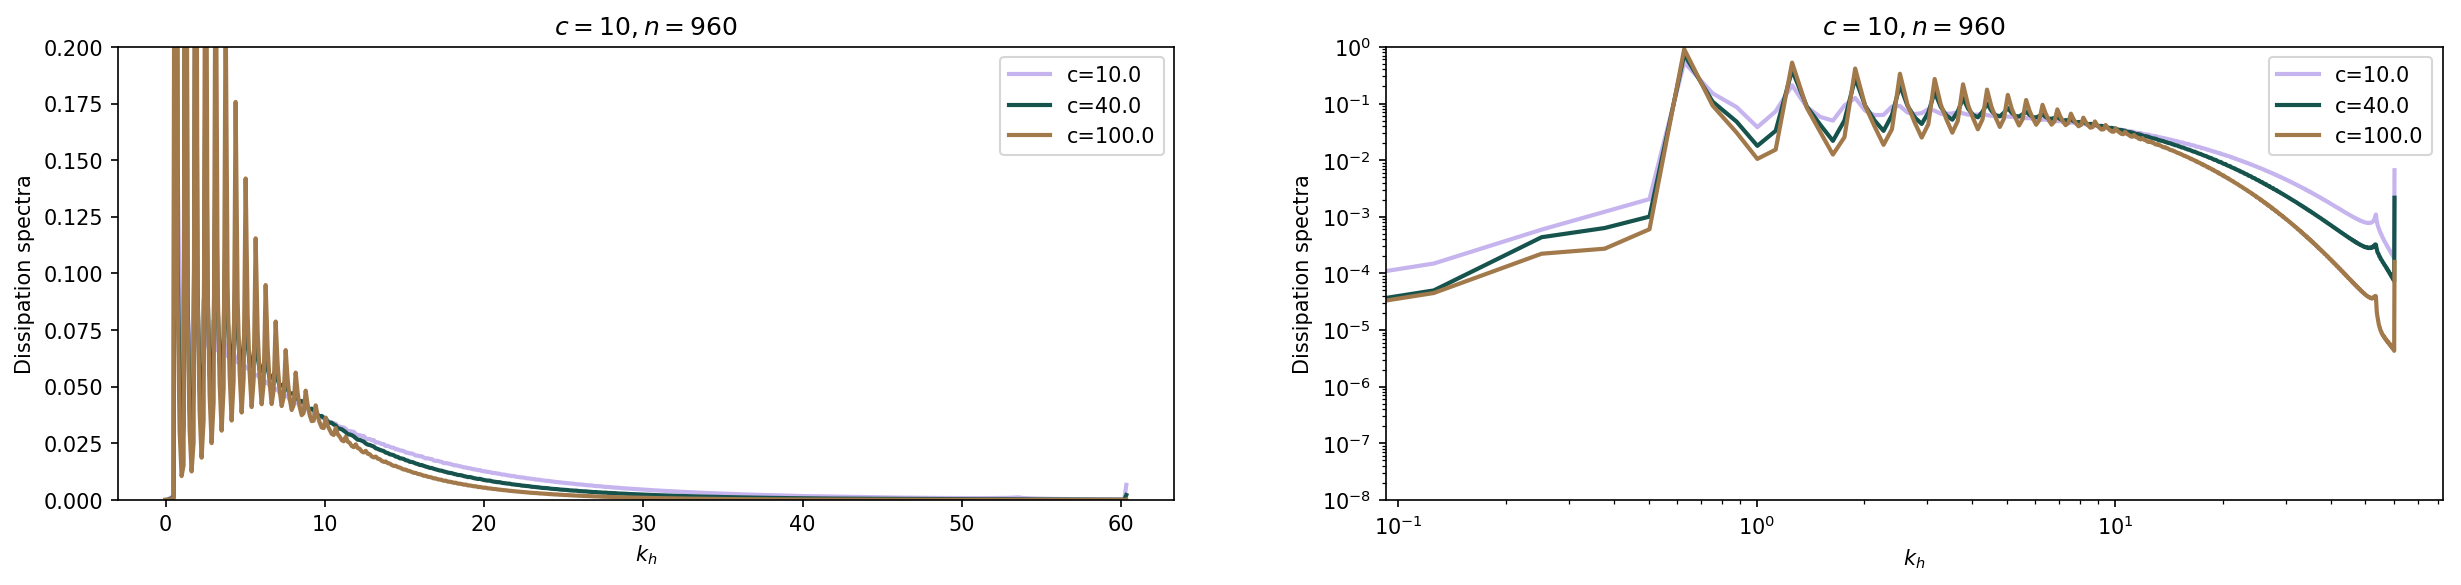

In [50]:
import seaborn as sns

fig, axes = plt.subplots(1,2, figsize=(20, 4), dpi=150)
ax0, ax1 = axes.ravel()
# colors = ["k", "r", "b", "g", "brown", "purple", "navy"]

cond = lambda df: (df.kmax_by_kdiss > 1.2) & (df.kmax_by_kdiss < 13) & (df.dealias > 0.5)
df_to_plot = df.where(cond).dropna()
colors = [mpl.colors.to_hex(c) for c in sns.color_palette("cubehelix", len(df))]
df_to_plot.sort_values("nu", inplace=True)

labels = []
for i, row in df_to_plot.iterrows():
    with stdout_redirected():
        sim = fls.load_sim_for_plot(row.path)
        for ax in axes:
            sim.output.spectra.plot_diss(tmin=5, delta_t=0, ax=ax, keys=["Dtot"], colors=(colors[i],), kh_norm=1)
    labels.append(
        f"c={sim.params.c2**0.5}"
        # "$k_{max}" + r"/k_d={:1.2f}, C_\nu={:1.1f}, \nu$={:1.2f}".format(row.kmax_by_kdiss, row.visc_const, row.nu)
    )

ax0.set_ylim(0, 0.2)
ax1.set_ylim(1e-8, 1)
ax0.set_yscale("linear")
ax0.set_xscale("linear")
ax1.set_yscale("log")
ax1.set_xscale("log")
for ax in axes:
    ax.set_title(r"$c=10, n=960$")
    lines = ax.get_lines()
    ax.set_ylabel("Dissipation spectra")
    ax.legend(lines, labels)

In [14]:
sim.params

NameError: name 'sim' is not defined

## Unscaled spectra

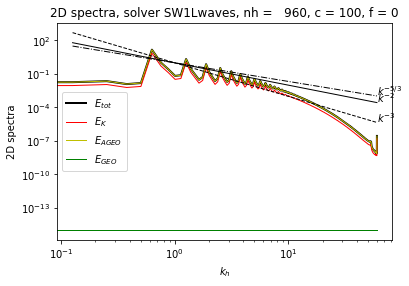

In [63]:
%%capture --no-display
sim.output.spectra.plot2d(tmin=5, delta_t=0, coef_compensate=0)

## Compensated spectra

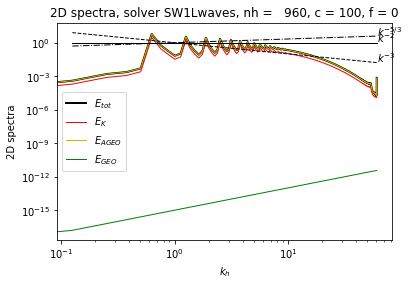

In [62]:
%%capture --no-display
sim.output.spectra.plot2d(tmin=15, delta_t=0, coef_compensate=2)

In [57]:
sim.params.nu_2

1.2354970683131095

(0, 5)

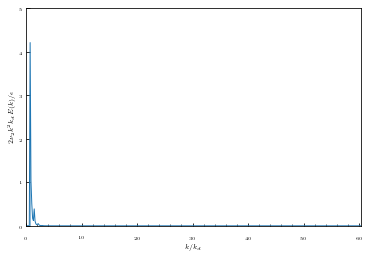

In [65]:
%%capture --no-display
import matplotlib.pyplot as plt
path = str(path_dir)
# path = str(path_dir).replace("tmp", "data")
fig, ax = plt.subplots()
fig7_spectra(path, fig, ax, 5, 0, nu_order=2)
ax.set_xlim(0, kmax)
ax.set_ylim(0, 5)

In [9]:
%%capture
import fluidsim as fls
sim = fls.load_state_phys_file()

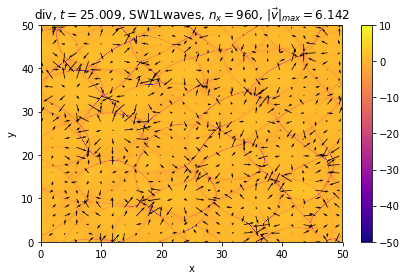

In [16]:
%%capture --no-display
%matplotlib inline
# plt.figure(dpi=200)
sim.output.phys_fields.plot("div",cmap="plasma", type_plot="pcolor", vmin=-50, vmax=10)